In [1]:
import sys; sys.path.append("../../")
from DataPreprocessing.DataPreprocessing import *
from DataExploration import *
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import sklearn.metrics as sm
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt

# Question:
    Predict sales of a game given Genre, platform, publisher and developer



## 1- Expectations: 
    The model should determine the game characteristics through year,developed,publisher
    and platform that best predict that sales of a game.

## Read Data 

In [2]:
df = read_data(kind='dataset')
df = df.dropna()

## EDA

### 1- Global sales distribution over all te genres

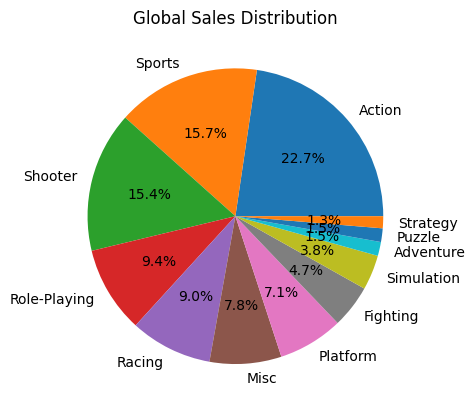

In [3]:
'''from the below pie chat we see that Genre with highest global sales Action
and the lowest is stratrgy'''
genres = df['Global_Sales'].groupby(df['Genre']).sum().sort_values(ascending=False).to_frame()
plt.pie(genres['Global_Sales'],labels = genres.index,autopct = '%1.1f%%') #plot first pie
plt.title('Global Sales Distribution')
plt.show()

### 2-Platforms with highest global sales

'from the below graph we see that Platform with highest global sales \nis PS2 and the lowest is DC'

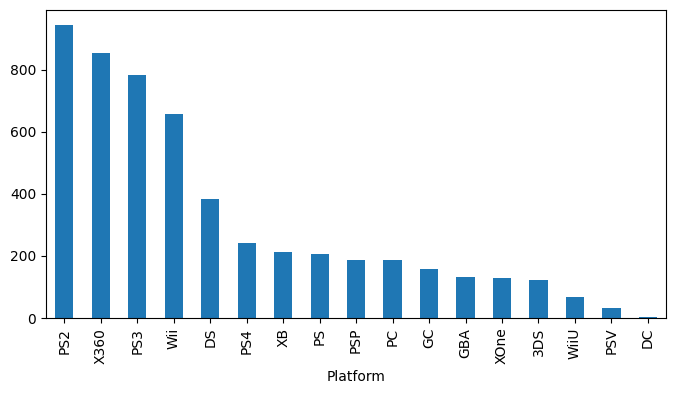

In [4]:
df.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(8,4))
'''from the below graph we see that Platform with highest global sales 
is PS2 and the lowest is DC'''


### 3- Top 50 developers with highest global sales

<Axes: xlabel='Developer'>

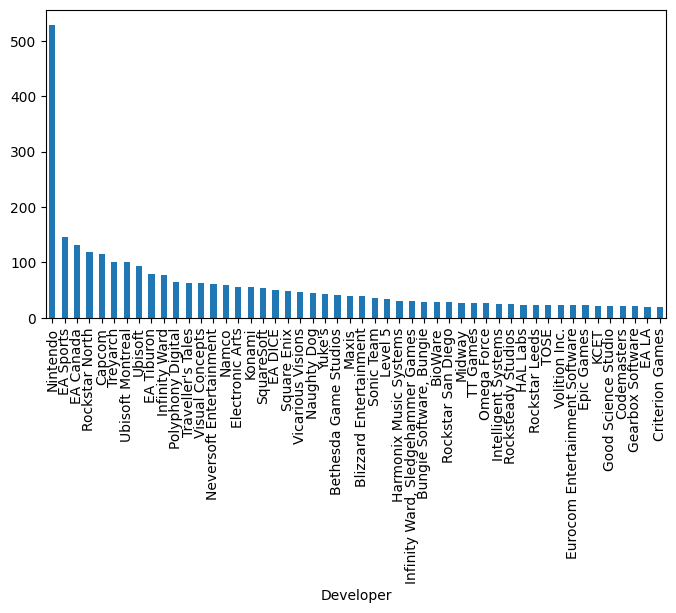

In [5]:
df.groupby('Developer')['Global_Sales'].sum().sort_values(ascending=False).head(50).plot(kind='bar', figsize=(8,4))


### 4- Top 20 Publishers

<Axes: xlabel='Publisher'>

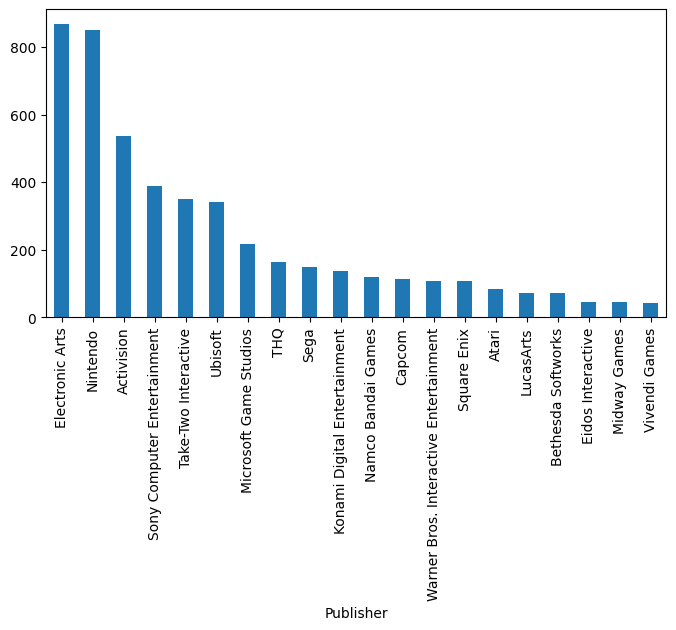

In [6]:
df.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=False).head(20).plot(kind='bar', figsize=(8,4))

### 5- Critic Score 

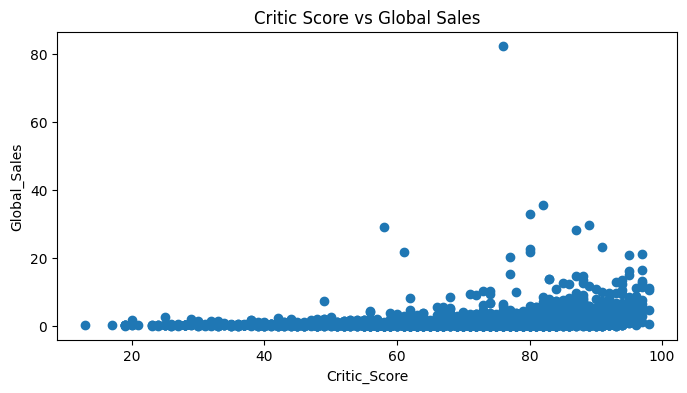

In [7]:
#plot critic score vs global sales
scatter(df,'Critic_Score','Global_Sales','Critic Score vs Global Sales')


In [8]:
#show outliers in the data
detect_outliers(df)

Number of outliers in Year_of_Release: 3
Number of outliers in NA_Sales: 704
Number of outliers in EU_Sales: 759
Number of outliers in JP_Sales: 1485
Number of outliers in Other_Sales: 786
Number of outliers in Global_Sales: 680
Number of outliers in Critic_Score: 105
Number of outliers in Critic_Count: 173
Number of outliers in User_Count: 982


## Read as train and val data frames

In [9]:
# read the data
df_train = read_data(kind='train')
df_val = read_data(kind='val')
# keep only the columns release year, publisher, developer,and platform 
# df_train = df_train[[ 'Publisher', 'Developer', 'Platform','Genre', 'Critic_Score','Rating','Global_Sales']]
df_val = df_val[['Publisher', 'Developer', 'Platform', 'Genre','Critic_Score', 'Rating','Global_Sales']]
df_train.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Akai Katana Shin,X360,2011.0,Shooter,Cave,0.04,0.00,0.01,0.00,0.06,NaN,NaN,NaN,NaN,NaN,NaN
1,One Piece: Unlimited World Red,WiiU,2014.0,Action,Namco Bandai Games,0.00,0.04,0.02,0.00,0.06,66.0,11.0,7.8,43.0,Ganbarion,T
2,Lunar Knights,DS,2006.0,Role-Playing,Konami Digital Entertainment,0.17,0.01,0.04,0.01,0.23,82.0,39.0,7.8,25.0,Kojima Productions,E10+
3,Secret Game Portable,PSP,2010.0,Adventure,Yeti,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
4,Far Cry 2,X360,2008.0,Action,Ubisoft,0.71,0.69,0.02,0.18,1.59,85.0,75.0,6.7,288.0,Ubisoft Montreal,M


## Handle Missing values


In [10]:
# handle missing values using mode imputation
df_train =handle_missing_values(df_train, handling_method='mode',neighbors=5)
df_val =handle_missing_values(df_val,handling_method='mode',neighbors=5)
df_train.head()

Total Number of rows : 10031
Number of rows with missing values: 5954
Total Number of rows : 3344
Number of rows with missing values: 1732


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Akai Katana Shin,X360,2011.0,Shooter,Cave,0.04,0.00,0.01,0.00,0.06,75.0,4.0,tbd,5.0,Ubisoft,E
1,One Piece: Unlimited World Red,WiiU,2014.0,Action,Namco Bandai Games,0.00,0.04,0.02,0.00,0.06,66.0,11.0,7.8,43.0,Ganbarion,T
2,Lunar Knights,DS,2006.0,Role-Playing,Konami Digital Entertainment,0.17,0.01,0.04,0.01,0.23,82.0,39.0,7.8,25.0,Kojima Productions,E10+
3,Secret Game Portable,PSP,2010.0,Adventure,Yeti,0.00,0.00,0.01,0.00,0.01,75.0,4.0,tbd,5.0,Ubisoft,E
4,Far Cry 2,X360,2008.0,Action,Ubisoft,0.71,0.69,0.02,0.18,1.59,85.0,75.0,6.7,288.0,Ubisoft Montreal,M


## prepare features and labels

In [11]:
# global sales our target column to be predicted
y_train = df_train['Global_Sales']
X_train = df_train.drop('Global_Sales', axis=1)
y_val = df_val['Global_Sales']
X_val = df_val.drop('Global_Sales', axis=1)
X_train.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Akai Katana Shin,X360,2011.0,Shooter,Cave,0.04,0.00,0.01,0.00,75.0,4.0,tbd,5.0,Ubisoft,E
1,One Piece: Unlimited World Red,WiiU,2014.0,Action,Namco Bandai Games,0.00,0.04,0.02,0.00,66.0,11.0,7.8,43.0,Ganbarion,T
2,Lunar Knights,DS,2006.0,Role-Playing,Konami Digital Entertainment,0.17,0.01,0.04,0.01,82.0,39.0,7.8,25.0,Kojima Productions,E10+
3,Secret Game Portable,PSP,2010.0,Adventure,Yeti,0.00,0.00,0.01,0.00,75.0,4.0,tbd,5.0,Ubisoft,E
4,Far Cry 2,X360,2008.0,Action,Ubisoft,0.71,0.69,0.02,0.18,85.0,75.0,6.7,288.0,Ubisoft Montreal,M


In [12]:
X_train.isnull().sum()  


Name               0
Platform           0
Year_of_Release    0
Genre              0
Publisher          0
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Critic_Score       0
Critic_Count       0
User_Score         0
User_Count         0
Developer          0
Rating             0
dtype: int64

# Models

## 1- catboost Model

In [13]:
# !pip install catboost

In [14]:
import catboost as cat
cat_feat =[ 'Publisher', 'Developer', 'Platform','Rating','Genre',]
model = cat.CatBoostRegressor(random_state=100,cat_features=cat_feat,verbose=0)
model.fit(X_train ,y_train)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="Akai Katana Shin": Cannot convert 'b'Akai Katana Shin'' to float

### Model Accuracy

In [ ]:
y_pred = model.predict(X_val)

In [ ]:
rmse = sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

1.000576625361013


In [ ]:
print("R2 score =", round(sm.r2_score( y_val, y_pred), 2))


R2 score = 0.12


## Encoding for cat features for the coming models

In [ ]:
X_train.head()
encoding(X_train)

,Publisher,Developer,Platform,Genre,Critic_Score
0,0.000698,0.410627,0.075167,0.077360,75.0
1,0.054930,0.000299,0.008872,0.198684,66.0
2,0.045559,0.000498,0.129798,0.090719,82.0
3,0.000698,0.410627,0.069485,0.078257,75.0
4,0.055428,0.005682,0.075167,0.198684,85.0
...,...,...,...,...,...
10026,0.021932,0.000698,0.071877,0.198684,62.0
10027,0.001894,0.000199,0.033297,0.075167,55.0
10028,0.000698,0.000498,0.049048,0.052836,61.0
10029,0.060413,0.002094,0.077958,0.052836,75.0


### 2- ElasticNet Model

In [ ]:
regr = ElasticNet(alpha=0.1)
# Prepare input data (frequncy encoding)
regr.fit(encoding(X_train), y_train)

ElasticNet(alpha=0.1)

In [ ]:
y_predicted =regr.predict(encoding(X_val))
print("R2 score =", round(sm.r2_score( y_val, y_predicted), 2))

R2 score = 0.07


### 3- Linear Regression Model

In [ ]:
reg = LinearRegression().fit(X_train, y_train)

In [ ]:
y_predicted =reg.predict(X_val)
# compute accuracy
print("R2 score =", round(sm.r2_score( y_val, y_predicted), 2))



R2 score = 0.09


## 3- Comparing Expectations to data:
       - year of realese didn't affect the score at all with increase or decrease 0.12
       - rating (class of the game) make the score very low 0.7
       - adding critic score to the feature 0.2
       - 